<a href="https://colab.research.google.com/github/LukaPavlovicGit/Concurrent-Algorithms/blob/main/GeneExpression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paralelni algoritmi - Drugi projekat

- Projekat se radi individualno ili u paru

- Rok za predaju projekata je **sreda 21.12.2022, do kraja dana (23:59)**. 

- Odbrane će biti organizovane u toku kolokvijumske nedelje.

- Predaja projekata je putem e-maila, programski kod bi trebalo da
bude prikacen uz sam e-mail. Subject e-maila treba da bude u formatu
"[RN3RA Projekat 1] Prezime (Prezime ukoliko se radi u paru)". Tekst e-maila treba da bude u formi:
"Ime Prezime XX/GGRN" (gde su XX i GG broje indeksa i godina upisa).
Link ka Collab-u je opcion. Ukoliko dva
studenta rade u paru, dovoljno je da jedan od njih preda, pri cemu
drugog stavi u cc.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Uvod 
Ekspresiju gena možemo meriti tako što u uzorku tkiva izmerimo količinu RNK molekula poteklu sa transkripata tog gena (više informacija na ovu temu će biti obrađeno u okviru predmeta Uvod u bioinformatiku u sledećem semetru; za potrebe ovog kursa dovoljno je da ekspresije posmatramo kao matrice brojeva).  

SC RNA-seq je tehnologija koja nam omogućava da merimo ekspresije gena na nivou pojedinačnih ćelija u uzorku. Dakle, podaci sa kojima radimo je matrica čiji redovi označavaju različite gene, kolone različite ćelije iz uzorka, a vrednosti predstavljaju ekspresiju datog gena u datoj ćeliji.

U okviru ovog projekta ćete implementirati standardne korake pri obradi SC RNA-seq podataka, ali koristeći map/reduce pristup.  

Uobičajen način razmišljanja o SC RNA-seq podacima je da ih posmatramo kao podakte o skupu ćelija, pri čemu je svaka ćelija jedna (multidimenzionalna) tačka predstavljenom vektorom genskih ekspresija izmerenih za tu ćeliju. 
- Često želimo da pronađemo grupe (klastere) ćelija, gde su ćelije sličnih ekspresija svrstane u istu grupu
- Često je korisno podatke prikazati u 2D (kako bi mogli da vidimo grupe), i za to se uglvnom koriste tehnike redukcije dimenzionalnosti kao što su TSNE ili UMAP. Detalji ovih metoda prevazilaze okvire ovog kursa, pa su je projekat dati i UMAP istog skupa podataka koji obrađujemo u okviru projekta.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


df = pd.read_table('/content/drive/MyDrive/ekspresije.tsv', index_col=0)
data = [(cell, gene, value) for cell in df.columns 
                            for gene, value in df[cell].iteritems()]

embedding = pd.read_table('/content/drive/MyDrive/umap.tsv')
embedding['cluster'] = 0
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding.umap1,
    embedding.umap2,
    c=[sn.color_palette()[x] for x in embedding.cluster]
)

# Zadatak

Data je matrice geneteskih ekspresija dobijenih SC RNA-seq tehnologijom. Potrebno je napisati kod koji radi sledecu obradu.

Matricu možete učitati u format pogodan za dalju obradu slecećim kodom:

```python
import pandas as pd
df = pd.read_table('ekspresije.tsv', index_col=0)
data = [(cell, gene, value) for cell in df.columns 
                            for gene, value in df[cell].iteritems()]
```
Uz matricu vrednosti je data i matrica UMAP vrednosti za svaku ćeliju. UMAP možete učitati i nacrtati sledećim kodom:
```python
import matplotlib.pyplot as plt
import seaborn as sn

embedding = pd.read_table('umap.tsv')
embedding['cluster'] = 0
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding.umap1,
    embedding.umap2,
    c=[sn.color_palette()[x] for x in embedding.cluster]
)
```
U sklopu zataka će biti potrebni odrediti klastere kojima ćelije pripadaju, pa će linija:
```python
embedding['cluster'] = 0
```
Biti zamenjena linijom koja upisu izračunate klastere. Na primer, ako imamo map oblika `klasteri = {'cell_id': 'cluster_id'}`:
```python
embedding['cluster'] = embedding.cell.map(klasteri)
```

#  1. Normalizacija unutar ćelija

- (1.1) Pomoću funkcije reduce odrediti srednju vrednost eksresija gena unutar svake ćelije.  
  Rezultat formirati kao niz tuple-ova (ćelija, srednja-vrednost). Poslednji element rezultata možete izmeniti nakon poziva funkcije reduce. **(1.5 bod)**

- (1.2) Pomoću funkcije map izrvšiti centriranje vrednosti ekspresija oko srednje vrednosti unutar date ćelije.   
  Rezultat treba da bude niz tuple-ova (ćelija, gen, vrednost - srednja-vrednost-u-ćeliji).   
  Radi rešavanja ove tačke niz srednjih vrednosti iz prethodne tačke možete pretvoriti u mapu (dict). **(1 bod)**

- (1.3) Pomoću funkije reduce odrediti odrediti varijansu ekspresija unutar svake ćelije, polazeći od rezultata iz prethodnog koraka.  
Rezultat treba da bude niz tuple-ova (ćelija, varijansa-vrednosti-u-ćeliji). Poslednji element rezultata možete izmeniti nakon poziva funkcije reduce. **(1 bod)**

- (1.4) Pomoću funkcije map odrediti standardnu devijaciju ekspresija unutar svake ćelije, polazeći od niza varijansi iz tačke (1.3). Rezultat formirati kao niz tuple-ova (ćelija, standardna devijacija). **(0.5 bodova)**

- (1.5) Pomoću funkcije map izrvšiti izvršiti stadnardizaciju vrednosti ekspresija unutar svake ćelije, polazeći od niza iz u tačke (1.2). Rezultat treba da bude niz tuple-ova (ćelija, gen, vrednost). Radi rešavanja ove tačke, rezultat  tačke (1.4) možete pretvoriti u mapu (dict). **(1 bod)**


### Defnicije operacija
- Centriranje vrednosti ekspresija oko srednje vrednosti niza: oduzimanje srednje vrednosti niza od svih elemenata niza
- Stadnardizacija vrednosti niza $z = \frac{x - x_{srednje}}{\sigma}$, pri čemu je $x_{srednje}$ srednja vrednost niza, a $\sigma$ standardna devijacija.

# 2. Nomralizacija vrednosti ekspresije gena

- (2.1) Pomoću funkija `map` i `reduce` odrediti varijansu ekspresija za svaki gen. Kao ulaz koristi niz kreiran u stavci (1.5), koji prethodno mozete sortirati po imenu gena. Možete primeniti istu skevencu koraka kao u tačkama 1.1-1.3 (računanje srednjih vrednosti, centriranje, pa varijansa).
Rezultat treba da bude niz tuple-ova (gen, varijansa-vrednosti-gena). Poslednji element rezultata možete izmeniti nakon poziva funkcije reduce. **1 bod**

- (2.2) Pomoću funckije `reduce` odrediti skup od 500 najvarijabilnijh gena. Kao ulaz koristi niz kreiran u stavci (2.1), koji možete prethodno sortirati standardnim metodama. **1 bod**

- (2.3) Pomoću funkcije `reduce` filtirati niz iz tačke (1.5) tako da sadrži samo gene koji se nalaze u 500 najvarijabilnijih gena. **1 bod**

- (2.4) Sortirati niz kreiran u zadatku (2.3), tako da bude leksikografki sortiran po imenu gena (sve vrednosti izmerene za isti gen će se tako naći jedna do druge), a unutar jednog gena opadajuće po vrednosti normalizovane ekspresije.  
Rezultat treba da bude niz tuple-ova (ćelija, gen, vrednost).  
U okviru ove tačke možete koristi python funkciju `sorted`. 

- (2.5) Pomoću funkcije `reduce` izvršiti rank normalizaciju vrednosti unutar jednog gena (najmanja izmerena vrednost gena u bilo kojoj ćeliji će dobiti vrednost 1, sledeća 2 itd. Ako je za neki gen izmerena ista vrednost u dve ćelije, rang će biti ponovljen).  
Rezultat treba da bude niz tuple-ova (ćelija, gen, originalna-vrednost, rank-vrednost): **1.5 bod**

- (2.6) Pomoću funkcije map izbaciti originalne vrednosti (pre rank normalizacije) iz niza iz tačke 2.2. **0.5 bodova**

# 3. K-means klasterovanje

- (3.1) Pomoću funkcije reduce grupisati vrednosti iz niza iz tačke (2.5) prema ćeliji.  
Rezultat treba da bude niz čiji su elementi tuple-ovi, takvi da je prvi element tuple-a identifikator ćelije, a drugi element niz vrednosti za sve gene izmerene u toj ćeliji.  
Vrednosti za različite gene moraju da se pojavljuju istim redosledom kod svih ćelija.: **2 boda**

- (3.2) Pomoću funkcija map i reduce implementriati k-means klasterovanje.  Klasterovati podatke u 2, 4, 6 i 10 klastera i prikazati rezultate bojenjem UMAP grafikona (UMAP kooridnate su date u posebnom fajlu).  
Nacrtati UMAP grafikone posle 1, 10 i 250 iteracija optimizacije **8 bodova**

#1. Normalizacija unutar ćelija

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn
from functools import reduce 
from itertools import starmap 
import itertools
import math

df = pd.read_table('/content/drive/MyDrive/ekspresije.tsv', index_col=0) 

data = [(cell, gene, value) for cell in df.columns 
                            for gene, value in df[cell].iteritems()]

def find_cell_meanValue(accumulator, tuple): 
  if not accumulator: 
    accumulator = [[tuple[0], tuple[2], 1]] 
  elif accumulator[-1][0] == tuple[0] : 
    accumulator[-1][1] += tuple[2] 
    accumulator[-1][2] += 1 
  else: 
    accumulator[-1] = [accumulator[-1][0], accumulator[-1][1] / accumulator[-1][2]] 
    accumulator = accumulator + [[tuple[0], tuple[2], 1]] 
  return accumulator

def center_cell_values(tuple, meanValue):
  return tuple[0], tuple[1], tuple[2] - meanValue

def find_cell_variance(accumulator, tuple): 
  if not accumulator: 
    accumulator = [[tuple[0], pow(tuple[2], 2), 1]] 
  elif accumulator[-1][0] == tuple[0]: 
    accumulator[-1][1] += pow(tuple[2], 2) 
    accumulator[-1][2] += 1 
  else: 
    accumulator[-1] = [accumulator[-1][0], accumulator[-1][1] / accumulator[-1][2]] 
    accumulator = accumulator + [[tuple[0], pow(tuple[2], 2), 1]] 
  return accumulator

def find_cell_deviation(cell_name, cell_variance):
  return cell_name, math.sqrt(cell_variance)

def standardization_of_cell_values(tuple, meanValue, deviation):
  return tuple[0], tuple[1], (tuple[2] - meanValue) / deviation

# 1.1 Trazimo srednje vrednosti gena unutar svake celije
cell_mean_values = reduce(find_cell_meanValue, data, []) 
cell_mean_values[-1] = [cell_mean_values[-1][0], cell_mean_values[-1][1] / cell_mean_values[-1][2]]

  # Skaliramo srednje vrednosti unutar celija tako da se svaka srednja vrednost pojavi onoliko puta koliko ima gena
scaled_cell_mean_values = [[tuple[1]] * 5068 for tuple in cell_mean_values]
  # array flatten
scaled_cell_mean_values = list(itertools.chain(*scaled_cell_mean_values))

# 1.2 Centriramo vrednosti gena oko srednje vrednosti unutar svake celije
centered_cell_values = map(center_cell_values, data, scaled_cell_mean_values)

# 1.3 Trazimo vrednost varijanse unutar svake celije (varijansa celije = suma kvadrata vrednosti gena celije / broj gena)
cell_variances = reduce(find_cell_variance, centered_cell_values, [])
cell_variances[-1] = [cell_variances[-1][0], cell_variances[-1][1] / cell_variances[-1][2]]

# 1.4 Trazimo vrednost devijacije unutar svake celije (devijacija celije = sqrt(varijansa celije))
cell_deviations = starmap(find_cell_deviation, cell_variances)

  # Skaliramo devijacije unutar celija tako da se svaka devijacije pojavi onoliko puta koliko ima gena
scaled_cell_deviations = [[tuple[1]] * 5068 for tuple in cell_deviations] 
  # array flatten
scaled_cell_deviations = list(itertools.chain(*scaled_cell_deviations))

# 1.5 Racunamo standardizaciju vrednosti gena unutar svake celije kao sto je opisano u zadatku
standardized_cell_values = list(map(standardization_of_cell_values, data, scaled_cell_mean_values, scaled_cell_deviations))

#2. Nomralizacija vrednosti ekspresije gena

---



In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn 
import functools
import itertools
import math

def compare1(str1, str2):
  if len(str1) < len(str2):
    return -1

  if len(str1) == len(str2):
    if str1 < str2:
      return -1
  
  return 1

def compare2(tuple1, tuple2):
  if tuple1[1] < tuple2[1]:
    return 1
  
  if tuple1[1] == tuple2[1]:
    if tuple1[2] < tuple2[2]:
      return 1

  return -1

def find_gene_meanValue(accumulator, tuple):
  if not accumulator:
    accumulator = [[tuple[1], tuple[2], 1]]
  elif accumulator[-1][0] == tuple[1]:
    accumulator[-1][1] += tuple[2]
    accumulator[-1][2] += 1
  else:
    accumulator[-1] = [accumulator[-1][0], accumulator[-1][1] / accumulator[-1][2]]
    accumulator = accumulator + [[tuple[1], tuple[2], 1]]
  return accumulator

def center_gene_values(tuple, meanValue):
  return tuple[0], tuple[1], tuple[2] - meanValue

def find_gene_variance(accumulator, tuple): 
  if not accumulator: 
    accumulator = [[tuple[1], pow(tuple[2], 2), 1]] 
  elif accumulator[-1][0] == tuple[1]: 
    accumulator[-1][1] += pow(tuple[2], 2) 
    accumulator[-1][2] += 1 
  else: 
    accumulator[-1] = [accumulator[-1][0], accumulator[-1][1] / accumulator[-1][2]] 
    accumulator = accumulator + [[tuple[1], pow(tuple[2], 2), 1]] 
  return accumulator

def the_500_most_variable_genes(accumulator, tuple):
  if len(accumulator) < 500:
    return accumulator + [tuple]
  return accumulator

def filter_standardized_cell_values(accumulator, tuple):
  if tuple[1] in accumulator[:500]:
    return accumulator + [tuple]
  return accumulator

def assign_ranks_inside_genes(accumulator, tuple): # tuple[0] = cellname, tuple[1] = genename, tuple[2] = value
  if not accumulator:
    return [[tuple[0], tuple[1], tuple[2], 1]]
  if accumulator[-1][1] == tuple[1]:
    if accumulator[-1][2] == tuple[2]:
      return accumulator + [[tuple[0], tuple[1], tuple[2], accumulator[-1][3]]]
    return accumulator + [[tuple[0], tuple[1], tuple[2], accumulator[-1][3] + 1]]

  return accumulator + [[tuple[0], tuple[1], tuple[2], 1]]

def remove_original_values(tuple):
  return tuple[0], tuple[1], tuple[3]

# novi data set sortiran po imenu gena
new_data = sorted(standardized_cell_values, key=lambda x: x[1])

# 2.1 
  # Trazimo srednje vrednosti gena unutar svakog gena 
gene_mean_values = reduce(find_gene_meanValue, new_data, [])
gene_mean_values[-1] = [gene_mean_values[-1][0], gene_mean_values[-1][1] / gene_mean_values[-1][2]]

  # Skaliramo sredje vrednosti unutar gena tako da se svaka srednja vrednost pojavi onoliko puta koliko ima celija
scaled_gene_mean_values = [[tuple[1]] * 534 for tuple in gene_mean_values]
  # array flatten
scaled_gene_mean_values = list(itertools.chain(*scaled_gene_mean_values))
  
  # Centriramo vrednosti celija oko srednje vrednosti unutar svakog gena
centered_gene_values = map(center_gene_values, new_data, scaled_gene_mean_values)

  # Trazimo vrednost varijanse unutar svake gena (varijansa gena = suma kvadrata vrednosti celija gena / broj celija)
gene_variances = reduce(find_gene_variance, centered_gene_values, [])
gene_variances[-1] = [gene_variances[-1][0], gene_variances[-1][1] / gene_variances[-1][2]]

# 2.2 Trazimo 500 najvarijabilnijih gena
gene_variances.sort(key=lambda x: x[1], reverse=True)
the_500_most_variable_genes = list(reduce(the_500_most_variable_genes, gene_variances, []))

# 2.3 Filtriramo niz iz 1.5 tako da sadzi samo najvarijabilnije gene
  # Kao accumulator je prosledjen niz imena 500 najvarijabilnijih gena
filtered_standardized_cell_values = list(reduce(filter_standardized_cell_values, 
                                                standardized_cell_values, 
                                                sorted([tuple[0] for tuple in the_500_most_variable_genes], key=functools.cmp_to_key(compare1)))) # mini optimizacija
  # Izbacujemo imena 500 najvarijabilnijih gena 
filtered_standardized_cell_values = filtered_standardized_cell_values[500:]

# 2.4 Sortirano niz iz 2.3 kao sto je opisano u zadatku
filtered_standardized_cell_values.sort(key=functools.cmp_to_key(compare2), reverse=True)

# 2.5 Odradjujemo rank normalizaciju unutar svakog gena
  # assigned_ranks_inside_genes[i][0] = cellname
  # assigned_ranks_inside_genes[i][1] = genename
  # assigned_ranks_inside_genes[i][2] = value
  # assigned_ranks_inside_genes[i][3] = rank
assigned_ranks_inside_genes = reduce(assign_ranks_inside_genes, filtered_standardized_cell_values, [])

# 2.6 Izbacujemo 'value' iz 2.5
assigned_ranks_inside_genes = list(map(remove_original_values, assigned_ranks_inside_genes))

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sn 
import functools
import itertools
import math


def compare3(tuple1, tuple2):
  if tuple1[0] < tuple2[0]:
    return -1
  if tuple1[0] == tuple2[0]:
    if tuple1[1] < tuple2[1]:
      return -1
    if tuple1[1] == tuple2[1]:
      return 0
  
  return 1 

def F3_1(accumulator, tuple): # accumulator[i][0] - 
  if not accumulator:
    accumulator = [[tuple[0], [tuple[2]]]]
  elif accumulator[-1][0] == tuple[0]:
    accumulator[-1][1] += [tuple[2]]
  else:
    accumulator += [[tuple[0], [tuple[2]]]]
  
  return accumulator

# 3.1 Grupisemo rankove iz 2.6  prema celijama
assigned_ranks_inside_genes.sort(key=functools.cmp_to_key(compare3))
  # assigned_ranks_inside_genes_grouped_by_cells[i][0] = cellname
  # assigned_ranks_inside_genes_grouped_by_cells[i][1] = array of ranks relative to gene names
assigned_ranks_inside_genes_grouped_by_cells = reduce(F3_1, assigned_ranks_inside_genes, [])

for i in range(4):
  print(assigned_ranks_inside_genes_grouped_by_cells[i])

['cell_0', [212, 192, 278, 288, 514, 107, 56, 288, 186, 170, 132, 65, 341, 131, 117, 336, 247, 105, 313, 153, 277, 167, 153, 361, 132, 402, 286, 52, 80, 149, 84, 347, 312, 293, 204, 113, 163, 309, 229, 250, 504, 284, 122, 292, 447, 403, 226, 120, 158, 205, 430, 218, 281, 321, 267, 304, 374, 314, 295, 428, 451, 218, 220, 357, 67, 295, 245, 166, 479, 508, 461, 232, 230, 155, 299, 175, 247, 163, 31, 328, 110, 359, 307, 263, 169, 317, 141, 76, 60, 491, 154, 280, 234, 242, 247, 154, 314, 188, 372, 364, 326, 182, 183, 78, 205, 287, 352, 389, 471, 47, 402, 1, 277, 332, 314, 57, 386, 241, 95, 505, 290, 299, 254, 479, 108, 326, 111, 232, 155, 306, 312, 31, 166, 74, 155, 185, 135, 28, 318, 251, 420, 124, 119, 131, 258, 155, 275, 522, 260, 420, 92, 146, 147, 141, 148, 143, 375, 107, 283, 282, 301, 314, 33, 373, 317, 290, 77, 51, 139, 209, 284, 395, 445, 480, 470, 447, 353, 289, 72, 75, 279, 172, 136, 129, 273, 283, 286, 346, 140, 231, 116, 125, 218, 362, 75, 199, 229, 278, 192, 139, 173, 190, 442

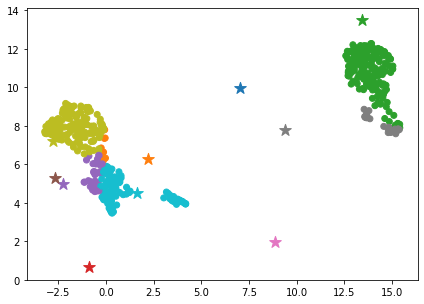

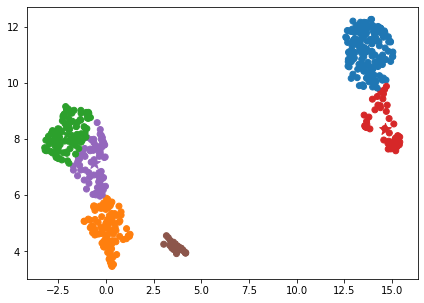

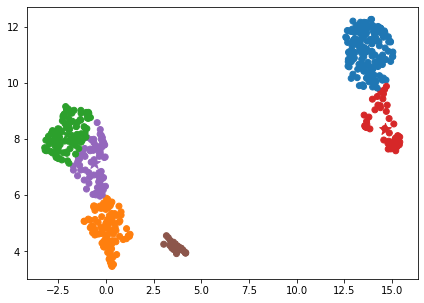

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn 
import functools
import itertools
import math
import sys
from decimal import Decimal


def min_max(accumulator, tuple):
  if not accumulator:
    accumulator = { 'map1': [tuple[0], tuple[0]], 'map2': [tuple[1], tuple[1]]}
  else:
    accumulator['map1'][0] = min(tuple[0], accumulator['map1'][0])
    accumulator['map1'][1] = max(tuple[0], accumulator['map1'][1])

    accumulator['map2'][0] = min(tuple[1], accumulator['map2'][0])
    accumulator['map2'][1] = max(tuple[1], accumulator['map2'][1])
  
  return accumulator

def cluster_assigmnet(accumulator, tuple):
  
  distance = Decimal(sys.maxsize)
  cellname_centroid = None

  for i in range(len(accumulator['centroids'])):
    tmp_distance = Decimal( np.sqrt(((accumulator['centroids'][i] - [float(tuple[1]), float(tuple[2])])**2).sum()) )
    if tmp_distance < distance:
      distance = tmp_distance
      cellname_centroid = {tuple[0]: i}

  accumulator.update(cellname_centroid)
  return accumulator

def calculate_centroids(accumulator, tuple):
  cell_values = accumulator['cells_values'][tuple[0]]
  if tuple[1] not in accumulator.keys():
    accumulator.update({ tuple[1]: [cell_values[0], cell_values[1], 1, cell_values[0], cell_values[1]] })
  else:
    accumulator[tuple[1]][0] += cell_values[0]
    accumulator[tuple[1]][1] += cell_values[1]
    accumulator[tuple[1]][2] += 1
    accumulator[tuple[1]][3] = accumulator[tuple[1]][0] / accumulator[tuple[1]][2]
    accumulator[tuple[1]][4] = accumulator[tuple[1]][1] / accumulator[tuple[1]][2]

  return accumulator

# 3.2 K-means klasterovanje

cell_names = [cell_names for cell_names in embedding['cell']]
umap1 = [x for x in embedding['umap1']]
umap2 = [x for x in embedding['umap2']]
zipped_umap1_umap2 = np.dstack((umap1, umap2))
  # trazimo minimalne i maksimalne vrednsti iz umap1 i umap2, zbog generisanja centroida
min_max_values = reduce(min_max, zipped_umap1_umap2[0], [])

k = 10
np.random.seed(3)
centroids = np.random.uniform(min(min_max_values['map1'][0], min_max_values['map2'][0]), max(min_max_values['map1'][1], min_max_values['map2'][1]), (k, 2))

# zipujemo cellnames, umap1 i umap2
zipped_cellnames_umap1_umap2 = np.dstack((cell_names, umap1, umap2))
# na ime celije umapiramo vrednosti umap1 i umap2 za datu celiju -> {cell_0: [x, y]}
mapped_cell_values = { tup[0]: [float(tup[1]), float(tup[2])] for tup in zipped_cellnames_umap1_umap2[0] }

for i in range(251):

  # Svakoj celiji dodeljujemo kom klasteru pripada
    # akumulator ce sadrzati vrednosti centroida 
  accumulator = {'centroids': centroids}
  assiged_clusters = reduce(cluster_assigmnet, zipped_cellnames_umap1_umap2[0], accumulator)
  del assiged_clusters['centroids']

  # ispis
  if i + 1 == 1 or i + 1  == 10 or i + 1 == 250:
    embedding['cluster'] = embedding.cell.map(assiged_clusters)
    plt.figure(figsize=(7, 5))

    [plt.scatter(*c, marker='*', s=150) for c in centroids]
    plt.scatter(
        embedding.umap1,
        embedding.umap2,
        c=[sn.color_palette()[x] for x in embedding.cluster],
    )

  # Racunamo nove vrednosti centorida
    # akumulator ce sadrzati imena celija i njene kordinate
  accumulator = {'cells_values': mapped_cell_values }
    # centroids ce biti formata -> [ {centroid_id: totalX, totalY, cnt, curResX, curResY}, ... ]
  centroids = reduce(calculate_centroids, 
                    [[key, val] for key, val in assiged_clusters.items()], 
                    accumulator)
  del centroids['cells_values']
    # cuvamo samo nove koordinate za svaki centroid
  centroids = np.array([[val[3], val[4]] for key, val in centroids.items()])